In [1]:
%pip install swig -q
%pip install gymnasium -q
%pip install gymnasium[box2d] -q
%pip install loky -q

In [27]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import pickle
import os

In [3]:
print("Versión de TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

Versión de TensorFlow: 2.18.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
env = gym.make('LunarLander-v3')
num_actions = env.action_space.n

In [5]:
class DQN(tf.keras.Model):
    """Perceptron multicapa de 2 capas de 32 y una de salida."""

    def __init__(self):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation="relu")
        self.dense2 = tf.keras.layers.Dense(32, activation="relu")
        self.dense3 = tf.keras.layers.Dense(num_actions, dtype=tf.float32)
        # No activation definida para la capa de salida

    def call(self, x):
        """Construcción de las capas."""
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

with tf.device('/GPU:0'):
    main_nn = DQN()
    target_nn = DQN()

# Optimizador Adam
optimizer = tf.keras.optimizers.Adam(1e-4)
# Función de pérdida (MSE)
mse = tf.keras.losses.MeanSquaredError()


In [6]:
class ReplayBuffer(object):
    """Experience replay buffer that samples uniformly."""

    def __init__(self, size):
        self.buffer = collections.deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        """Añade una experiencia al buffer."""
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, num_samples):
        """Obtiene una muestra aleatoria de experiencias y las convierte en tensores de TensorFlow."""
        batch = random.sample(self.buffer, num_samples)

        states, actions, rewards, next_states, dones = zip(*batch)

        # Convertir listas a arrays optimizados
        states = np.asarray(states, dtype=np.float32)
        actions = np.asarray(actions, dtype=np.int32)
        rewards = np.asarray(rewards, dtype=np.float32)
        next_states = np.asarray(next_states, dtype=np.float32)
        dones = np.asarray(dones, dtype=np.float32)

        # Convertir a tensores para usarlos directamente en TensorFlow/Keras
        states = tf.convert_to_tensor(states)
        actions = tf.convert_to_tensor(actions)
        rewards = tf.convert_to_tensor(rewards)
        next_states = tf.convert_to_tensor(next_states)
        dones = tf.convert_to_tensor(dones)

        return states, actions, rewards, next_states, dones


In [7]:
@tf.function
def select_epsilon_greedy_action(state, epsilon):
    """Acción aleatoria con probabilidad menor que epsilon, en otro caso la mejor."""

    epsilon = tf.convert_to_tensor(epsilon, dtype=tf.float32)  # Convertimos epsilon a tensor

    def random_action():
        return tf.random.uniform(shape=(), minval=0, maxval=num_actions, dtype=tf.int32)

    def greedy_action():
        return tf.argmax(main_nn(state)[0], axis=-1, output_type=tf.int32)

    # Usamos tf.cond() para manejar la bifurcación dentro de tf.function
    return tf.cond(tf.random.uniform(()) < epsilon, random_action, greedy_action)


@tf.function(jit_compile=True)
def train_step(states, actions, rewards, next_states, dones):
    """Configuración de cada iteración de entrenamiento optimizada en GPU."""

    # Cálculo de los Q-valores objetivo (segunda red)
    next_qs = target_nn(next_states)
    max_next_qs = tf.reduce_max(next_qs, axis=-1)

    # Evitamos cálculos innecesarios en el gráfico computacional
    target = rewards + (1. - dones) * discount * tf.stop_gradient(max_next_qs)

    with tf.GradientTape() as tape:
        qs = main_nn(states)
        action_masks = tf.one_hot(actions, num_actions, dtype=tf.float32)
        masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
        loss = mse(target, masked_qs)

    # Cálculo de gradientes y optimización
    grads = tape.gradient(loss, main_nn.trainable_variables)
    optimizer.apply_gradients(zip(grads, main_nn.trainable_variables))

    return loss


In [8]:
state = env.reset()
print("state type:", type(state))
print("state:", state)

state type: <class 'tuple'>
state: (array([-0.00593166,  1.4180748 , -0.60082865,  0.31797457,  0.0068801 ,
        0.13609672,  0.        ,  0.        ], dtype=float32), {})


In [9]:
# Hiperparámetros
num_episodes = 1000
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000)  # Memoria de experiencias
cur_frame = 0

# Almacenar recompensas y métricas
episode_rewards = []  # Recompensa por episodio
avg_rewards = []  # Promedio de los últimos 100 episodios
best_rewards = []  # Mejor recompensa encontrada hasta el momento
last_100_ep_rewards = collections.deque(maxlen=100)  # Últimos 100 episodios

# Carpeta donde guardar los datos y modelos
SAVE_PATH = "saved_model"
os.makedirs(SAVE_PATH, exist_ok=True)  # Crea la carpeta si no existe

for episode in range(num_episodes + 1):
    state, _ = env.reset()  # Reiniciar el entorno
    ep_reward = 0
    done = False

    while not done:
        # Convertir estado a tensor para usar en GPU
        state_in = tf.convert_to_tensor([state], dtype=tf.float32)

        # Selección de acción con política epsilon-greedy
        action = select_epsilon_greedy_action(state_in, epsilon).numpy()

        # Ejecutar la acción en el entorno
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        ep_reward += reward

        # Guardar experiencia en el buffer
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1

        # Copiar pesos de la red principal a la red objetivo cada 2000 frames
        if cur_frame % 2000 == 0:
            target_nn.set_weights(main_nn.get_weights())

        # Entrenamiento si hay suficientes datos en el buffer
        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            loss = train_step(states, actions, rewards, next_states, dones)

    # Actualizar epsilon (con mínimo de 0.05 para evitar valores negativos)
    epsilon = max(epsilon - 0.001, 0.05)

    # Guardar recompensa del episodio
    last_100_ep_rewards.append(ep_reward)
    episode_rewards.append(ep_reward)
    avg_rewards.append(np.mean(last_100_ep_rewards))

    if len(best_rewards) == 0:
        best_rewards.append(ep_reward)
    else:
        best_rewards.append(max(best_rewards[-1], ep_reward))

    # Imprimir progreso cada 50 episodios
    if episode % 50 == 0:
        print(f'Episode {episode}/{num_episodes} | Epsilon: {epsilon:.3f} | '
              f'Best Reward (last 100 eps): {best_rewards[-1]:.3f} | '
              f'Avg Reward (last 100 eps): {avg_rewards[-1]:.3f}')

# Guardar los datos de entrenamiento en un archivo pickle
train_data = {
    "episode_rewards": episode_rewards,
    "avg_rewards": avg_rewards,
    "best_rewards": best_rewards,
    "epsilon": epsilon  # Guardamos el valor final de epsilon
}

with open(os.path.join(SAVE_PATH, "train_data.pkl"), "wb") as f:
    pickle.dump(train_data, f)

# Guardar los pesos de la red neuronal
main_nn.save_weights(os.path.join(SAVE_PATH, "dqn_weights.weights.h5"))

# Guardar el Replay Buffer
with open(os.path.join(SAVE_PATH, "replay_buffer.pkl"), "wb") as f:
    pickle.dump(buffer, f)

print("✅ Entrenamiento finalizado y datos guardados correctamente.")
env.close()

Episode 0/1000 | Epsilon: 0.999 | Best Reward (last 100 eps): 1.547 | Avg Reward (last 100 eps): 1.547
Episode 50/1000 | Epsilon: 0.949 | Best Reward (last 100 eps): 30.961 | Avg Reward (last 100 eps): -175.082
Episode 100/1000 | Epsilon: 0.899 | Best Reward (last 100 eps): 30.961 | Avg Reward (last 100 eps): -185.743
Episode 150/1000 | Epsilon: 0.849 | Best Reward (last 100 eps): 30.961 | Avg Reward (last 100 eps): -180.663
Episode 200/1000 | Epsilon: 0.799 | Best Reward (last 100 eps): 30.961 | Avg Reward (last 100 eps): -160.234
Episode 250/1000 | Epsilon: 0.749 | Best Reward (last 100 eps): 30.961 | Avg Reward (last 100 eps): -147.991
Episode 300/1000 | Epsilon: 0.699 | Best Reward (last 100 eps): 32.971 | Avg Reward (last 100 eps): -126.195
Episode 350/1000 | Epsilon: 0.649 | Best Reward (last 100 eps): 32.971 | Avg Reward (last 100 eps): -107.601
Episode 400/1000 | Epsilon: 0.599 | Best Reward (last 100 eps): 32.971 | Avg Reward (last 100 eps): -105.436
Episode 450/1000 | Epsilon

In [46]:
# Carpeta donde están guardados los modelos y datos
SAVE_PATH = "saved_model"

# Cargar datos de entrenamiento previos
with open(os.path.join(SAVE_PATH, "train_data.pkl"), "rb") as f:
    train_data = pickle.load(f)

episode_rewards = train_data["episode_rewards"]
avg_rewards = train_data["avg_rewards"]
best_rewards = train_data["best_rewards"]
epsilon = train_data["epsilon"]

# Cargar los pesos de la red neuronal
main_nn = DQN()
main_nn.build(input_shape=(None, 8))  # Ajustar a la dimensión de entrada del estado
main_nn.load_weights(os.path.join(SAVE_PATH, "dqn_weights.weights.h5"))

# Cargar el Replay Buffer
with open(os.path.join(SAVE_PATH, "replay_buffer.pkl"), "rb") as f:
    buffer = pickle.load(f)

print("✅ Datos cargados correctamente. El entrenamiento puede continuar.")

import os

if os.path.exists(os.path.join(SAVE_PATH, "dqn_weights.weights.h5")):
    print("✅ Pesos del modelo guardados correctamente.")
else:
    print("❌ ERROR: No se encontraron los pesos del modelo guardados.")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'dqn_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Datos cargados correctamente. El entrenamiento puede continuar.
✅ Pesos del modelo guardados correctamente.


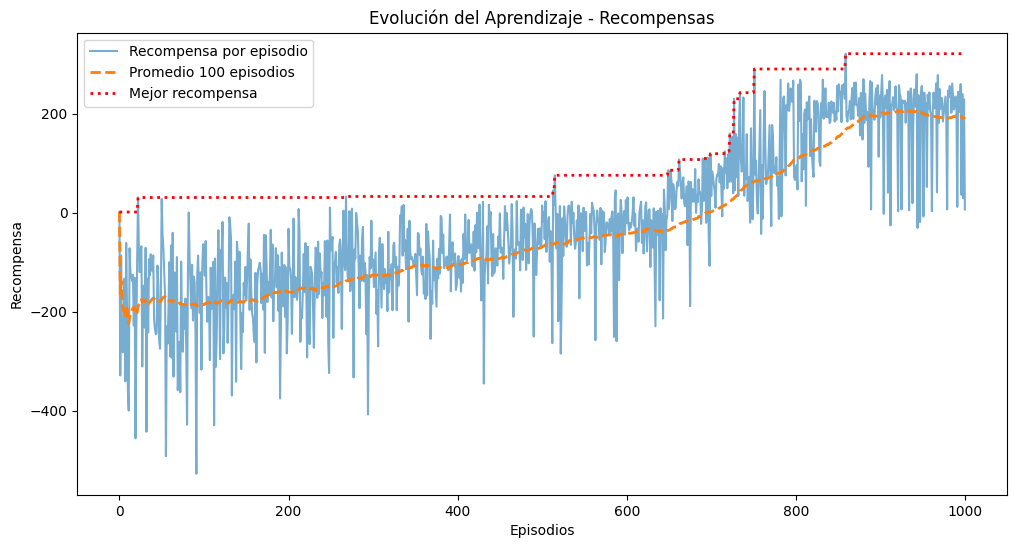

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Graficar todas las métricas en un solo gráfico
plt.plot(episode_rewards, label="Recompensa por episodio", alpha=0.6)
plt.plot(avg_rewards, label="Promedio 100 episodios", linestyle="dashed", linewidth=2)
plt.plot(best_rewards, label="Mejor recompensa", linestyle="dotted", color="red", linewidth=2)

# Configuración del gráfico
plt.xlabel("Episodios")
plt.ylabel("Recompensa")
plt.legend()
plt.title("Evolución del Aprendizaje - Recompensas")

plt.show()


In [43]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import os
from gym.wrappers import RecordVideo

# Carpeta donde están guardados los modelos y datos
SAVE_PATH = "saved_model"
VIDEO_PATH = "videos"

# Crear la carpeta de videos si no existe
os.makedirs(VIDEO_PATH, exist_ok=True)

# Crear entorno con grabación de video (activar `new_step_api=True`)
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
test_env = RecordVideo(test_env, VIDEO_PATH, episode_trigger=lambda episode_id: episode_id % 1 == 0)

# Reiniciar el entorno correctamente
reset_output = test_env.reset()
state = reset_output[0] if isinstance(reset_output, tuple) else reset_output

done = False
total_reward = 0

while not done:
    state_in = tf.convert_to_tensor(state, dtype=tf.float32)
    state_in = tf.expand_dims(state_in, axis=0)  # Asegurar forma (1, 8)

    action = tf.argmax(main_nn(state_in)[0], axis=-1).numpy()  # Elegir acción greedy

    # Manejar ambas versiones de Gymnasium
    step_output = test_env.step(action)

    if len(step_output) == 5:  # Nueva API de Gymnasium (5 valores)
        next_state, reward, done, truncated, _ = step_output
        done = done or truncated  # Unir `done` y `truncated`
    else:  # API antigua (4 valores)
        next_state, reward, done, _ = step_output

    total_reward += reward
    state = next_state

    test_env.render()  # Asegurar que los frames se rendericen para la grabación

test_env.close()

print(f"✅ Episodio completado. Recompensa total: {total_reward:.3f}")
print(f"🎥 Video guardado en {VIDEO_PATH}/")

# Verificar que el video se haya guardado correctamente
video_files = sorted([f for f in os.listdir(VIDEO_PATH) if f.endswith(".mp4")])

if len(video_files) > 0:
    print("📂 Videos guardados en la carpeta:")
    for video in video_files:
        print(f" - {video}")
else:
    print("❌ No se encontraron videos guardados.")


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅ Episodio completado. Recompensa total: -851.010
🎥 Video guardado en videos/
📂 Videos guardados en la carpeta:
 - rl-video-episode-0.mp4
